<a href="https://colab.research.google.com/github/akinivors/CENG543_Midterm_290201005/blob/main/Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Q1_Classification.ipynb

# 1. Imports
import torch
from datasets import load_dataset
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# 2. Set the device for MPS acceleration
# This is crucial for fast training on your Mac!
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA (T4 GPU) acceleration: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU) acceleration.")
else:
    device = torch.device("cpu")
    print("CUDA/MPS not available. Using CPU.")

# 3. Set a Global Seed for Reproducibility (Mandatory requirement)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 4. Load the IMDb Dataset
# This downloads and loads the raw data
imdb_dataset = load_dataset("imdb")

print("\nIMDb Dataset loaded successfully!")
print(imdb_dataset)

Using CUDA (T4 GPU) acceleration: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


IMDb Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# --- STEP 7.1.A: Tokenization and Vocabulary Building ---

# Use only the train and test splits for classification
train_texts = imdb_dataset['train']['text']
test_texts = imdb_dataset['test']['text']
train_labels = imdb_dataset['train']['label']
test_labels = imdb_dataset['test']['label']

# 1. Simple Tokenization Function
def simple_tokenize(text):
    # Convert to lowercase and split by space (basic, standard approach for GloVe)
    return text.lower().split()

# 2. Build Vocabulary Mapping
word_to_index = {"<unk>": 0, "<pad>": 1} # Initialize with UNK (unknown) and PAD (padding) tokens
index_to_word = {0: "<unk>", 1: "<pad>"}
MAX_VOCAB_SIZE = 25000 # Limit vocabulary size to speed up training and reduce memory

# Collect all tokens from the training set
all_tokens = [token for text in train_texts for token in simple_tokenize(text)]

# Count word frequency and select the top words
from collections import Counter
word_counts = Counter(all_tokens)
sorted_vocab = [word for word, count in word_counts.most_common(MAX_VOCAB_SIZE - 2)]

# Populate the final vocabulary
for word in sorted_vocab:
    if word not in word_to_index:
        index = len(word_to_index)
        word_to_index[word] = index
        index_to_word[index] = word

VOCAB_SIZE = len(word_to_index)
print(f"Vocabulary Size for GloVe: {VOCAB_SIZE}")

# 3. Text to Sequence Conversion and Padding
def numericalize(text, vocab, max_length=256):
    tokens = simple_tokenize(text)
    numericalized = [vocab.get(token, vocab["<unk>"]) for token in tokens]

    # Truncate and Pad
    if len(numericalized) > max_length:
        numericalized = numericalized[:max_length]
    elif len(numericalized) < max_length:
        numericalized.extend([vocab["<pad>"]] * (max_length - len(numericalized)))

    return numericalized

# Convert entire dataset
train_numericalized = [numericalize(text, word_to_index) for text in train_texts]
test_numericalized = [numericalize(text, word_to_index) for text in test_texts]

print(f"Training sequence example (first 10 indices): {train_numericalized[0][:10]}")

Vocabulary Size for GloVe: 25000
Training sequence example (first 10 indices): [9, 1486, 9, 226, 0, 34, 57, 433, 1495, 77]


In [ ]:
# --- STEP 7.1.B: Loading Pre-Trained GloVe Vectors (300d) - MODIFIED V2 (Using Requests) ---
import requests
import zipfile
import os

# Define file paths and URL
GLOVE_FILE = 'glove.6B.300d.txt'
GLOVE_ZIP = 'glove.6B.zip'
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'

# 0. CLEANUP: Delete any potentially corrupted files
if os.path.exists(GLOVE_FILE):
    os.remove(GLOVE_FILE)
if os.path.exists(GLOVE_ZIP):
    os.remove(GLOVE_ZIP)

if not os.path.exists(GLOVE_FILE):
    print("Downloading GloVe vectors (approx. 862 MB) using requests...")
    try:
        # 1. Download the ZIP file content
        response = requests.get(GLOVE_URL, stream=True)
        response.raise_for_status() # Check for bad status codes (4xx or 5xx)

        # 2. Save the ZIP file to disk
        with open(GLOVE_ZIP, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download successful.")

        # 3. Extract the file
        with zipfile.ZipFile(GLOVE_ZIP, 'r') as zip_ref:
            zip_ref.extract(GLOVE_FILE, '.')
        print("Extraction successful.")

    except requests.exceptions.RequestException as e:
        print(f"Network/Request Error: {e}")
        # Clean up partial download
        if os.path.exists(GLOVE_ZIP):
            os.remove(GLOVE_ZIP)
        raise # Stop execution if download fails

# --- CONTINUE LOADING INTO EMBEDDING MATRIX ---
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Load GloVe into the matrix (this part remains the same)
glove_found = 0
try:
    with open(GLOVE_FILE, 'r', encoding="utf8") as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if word in word_to_index:
                index = word_to_index[word]
                vector = np.array(parts[1:], dtype=np.float32)
                embedding_matrix[index] = vector
                glove_found += 1
except Exception as e:
    print(f"Error reading GloVe file: {e}")
    raise

print(f"\nLoaded {glove_found} pre-trained vectors into our matrix (out of {VOCAB_SIZE} words).")
print(f"Embedding Matrix Shape: {embedding_matrix.shape}")

Download successful.
Extraction successful.

Loaded 15813 pre-trained vectors into our matrix (out of 25000 words).
Embedding Matrix Shape: (25000, 300)


In [ ]:
# --- STEP 8: Prepare PyTorch DataLoaders and Final Hyperparameters ---
import torch.utils.data as data

# Convert lists to PyTorch Tensors (from Cell 2)
# Note: Ensure test_numericalized and train_numericalized are defined in Cell 2.
train_data = torch.LongTensor(train_numericalized)
test_data = torch.LongTensor(test_numericalized)

train_labels = torch.LongTensor(imdb_dataset['train']['label'])
test_labels = torch.LongTensor(imdb_dataset['test']['label'])

# Combine data and labels into TensorDatasets
train_dataset = data.TensorDataset(train_data, train_labels)
test_dataset = data.TensorDataset(test_data, test_labels)

# Define Hyperparameters (CRUCIAL: Defines OUTPUT_DIM)
BATCH_SIZE = 64
OUTPUT_DIM = 2 # Positive/Negative sentiment (The missing variable!)
# Dimensions defined here are required for the models in Cell 5

# Create DataLoaders (used to feed data in batches during training)
train_iterator = data.DataLoader(train_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)

test_iterator = data.DataLoader(test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

print("\nDataLoaders and core hyperparameters successfully created.")


DataLoaders and core hyperparameters successfully created.


In [ ]:
# --- STEP 15.1: Define the Recurrent Classification Model (Corrected) ---
import torch.nn as nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, rnn_type='LSTM'):
        super().__init__()

        # FIX: Store rnn_type for use in the forward method
        self.rnn_type = rnn_type

        # 1. Embedding Layer: Initialized with the GloVe matrix
        # Set padding_idx to 1 (our <pad> token) so the model ignores it.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. Recurrent Layer: Use LSTM or GRU based on rnn_type argument
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim,
                               hidden_dim,
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout,
                               batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim,
                              hidden_dim,
                              num_layers=n_layers,
                              bidirectional=bidirectional,
                              dropout=dropout,
                              batch_first=True)
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}. Must be 'LSTM' or 'GRU'.")

        # 3. Output Layer: Maps the final RNN output to the 2 classes (Positive/Negative)
        # Multiply by 2 because we are using a BIDIRECTIONAL RNN.
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        # 4. Dropout Layer (for regularization)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, seq len]

        # Apply dropout to the embeddings layer
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, seq len, emb dim]

        # Pass through the RNN
        # GRU returns (output, hidden); LSTM returns (output, hidden, cell)
        if self.rnn_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else: # rnn_type == 'GRU'
            output, hidden = self.rnn(embedded)
        # output = [batch size, seq len, hid dim * num directions]
        # hidden = [num layers * num directions, batch size, hid dim]

        # Take the final hidden state from both directions (the last two layers of the hidden state tensor)
        # hidden[-2,:,:] is the final forward hidden state
        # hidden[-1,:,:] is the final backward hidden state
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        # hidden = [batch size, hid dim * 2]

        return self.fc(hidden)

In [ ]:
# --- STEP 15.2: Initialize and Setup Models ---

# Hyperparameters (These will be the SAME for all Q1 models for fair comparison)
HIDDEN_DIM = 256
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = 1 # Our <pad> token index

# 1. Initialize the Bi-LSTM Model
lstm_model = RNNClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=True,
    dropout=DROPOUT,
    pad_idx=PAD_IDX,
    rnn_type='LSTM'
).to(device)

# 2. Initialize the Bi-GRU Model
gru_model = RNNClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=True,
    dropout=DROPOUT,
    pad_idx=PAD_IDX,
    rnn_type='GRU'
).to(device)

# 3. Apply GloVe Weights (Transfer Learning)
# Convert the NumPy matrix to a PyTorch tensor
glove_weights = torch.FloatTensor(embedding_matrix).to(device)

# Replace the initial weights of the embedding layer with GloVe
lstm_model.embedding.weight.data.copy_(glove_weights)
gru_model.embedding.weight.data.copy_(glove_weights)

# Freeze the embedding layer? (Optional, but often done for static embeddings)
# We will keep it unfrozen for now to allow fine-tuning, but note this for ablation/discussion.

print("Bi-LSTM and Bi-GRU models initialized with GloVe embeddings.")
print(f"Bi-LSTM total parameters: {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad):,}")
print(f"Bi-GRU total parameters: {sum(p.numel() for p in gru_model.parameters() if p.requires_grad):,}")

Bi-LSTM and Bi-GRU models initialized with GloVe embeddings.
Bi-LSTM total parameters: 10,220,770
Bi-GRU total parameters: 9,540,834


In [ ]:
# --- STEP 20.1: Define Optimizer, Loss, and Metric Functions ---
import torch.optim as optim
from sklearn.metrics import f1_score

# 1. Define Optimizer and Criterion (Loss Function)
# Use Adam optimizer as a standard choice for deep learning.
optimizer_lstm = optim.Adam(lstm_model.parameters())
optimizer_gru = optim.Adam(gru_model.parameters())

# Use CrossEntropyLoss for the classification task.
# We will pass the raw output (logits) to the loss function.
criterion = nn.CrossEntropyLoss().to(device)

# 2. Define Metric Function (Macro F1 and Accuracy)
def calculate_accuracy(preds, y):
    """Calculates standard accuracy."""
    # preds: model predictions (logits)
    # y: true labels (0 or 1)

    # Get the index of the max log-probability (which is the prediction)
    max_preds = preds.argmax(dim=1)
    correct = (max_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def calculate_macro_f1(preds, y):
    """Calculates Macro F1 Score using scikit-learn."""
    max_preds = preds.argmax(dim=1)
    # Move tensors to CPU for scikit-learn calculation
    return f1_score(y.cpu().numpy(), max_preds.cpu().numpy(), average='macro')

print("Optimizer, Loss function, and metric functions defined.")

Optimizer, Loss function, and metric functions defined.


In [ ]:
# --- STEP 20.2: Define Training and Evaluation Loops (MODIFIED) ---

# 1. Training Function
def train(model, iterator, optimizer, criterion):
    # Training Loop
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        # Check if batch is a dictionary (BERT) or a tuple (GloVe)
        if isinstance(batch, dict):
            # BERT/Contextual Model Logic (3 items: input_ids, attention_mask, labels)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Contextual RNN Model requires two inputs
            predictions = model(input_ids, attention_mask)

        else:
            # GloVe/Static Model Logic (2 items: text, labels)
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            # RNNClassifier Model requires one input
            predictions = model(text)

        # Zero the gradients (clear previous batch's gradients)
        optimizer.zero_grad()

        # Calculate loss and metrics (same for both)
        loss = criterion(predictions, labels)
        acc = calculate_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 2. Evaluation Function
def evaluate(model, iterator, criterion):
    # Evaluation Loop
    model.eval() # Set model to evaluation mode (disables dropout/batchnorm)
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0

    with torch.no_grad(): # Disable gradient calculation
        for batch in iterator:
            if isinstance(batch, dict):
                # BERT/Contextual Model Logic
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                predictions = model(input_ids, attention_mask)
            else:
                # GloVe/Static Model Logic
                text, labels = batch
                text, labels = text.to(device), labels.to(device)

                predictions = model(text)

            loss = criterion(predictions, labels)
            acc = calculate_accuracy(predictions, labels)
            f1 = calculate_macro_f1(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

print("Training and Evaluation functions defined (Compatibility Mode).")

Training and Evaluation functions defined (Compatibility Mode).


In [ ]:
# --- STEP 25.1: DistilBERT Tokenizer Setup ---
from transformers import AutoTokenizer

# Load the DistilBERT tokenizer
BERT_MODEL_NAME = 'distilbert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

# Check the max sequence length and special tokens
MAX_SEQ_LEN = 512 # Standard max length for BERT models
print(f"DistilBERT Tokenizer loaded. Vocabulary size: {bert_tokenizer.vocab_size}")
print(f"Tokenizing an example: {bert_tokenizer.tokenize('This is an example sentence.')}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBERT Tokenizer loaded. Vocabulary size: 30522
Tokenizing an example: ['this', 'is', 'an', 'example', 'sentence', '.']


In [ ]:
# --- STEP 25.2: Tokenization and DataLoaders for BERT ---
from datasets import Dataset

# 1. Convert lists back to a Hugging Face Dataset format for easy mapping
raw_train_data = {'text': imdb_dataset['train']['text'], 'label': imdb_dataset['train']['label']}
raw_test_data = {'text': imdb_dataset['test']['text'], 'label': imdb_dataset['test']['label']}

train_hf_dataset = Dataset.from_dict(raw_train_data)
test_hf_dataset = Dataset.from_dict(raw_test_data)

# 2. Define the tokenization function using the BERT tokenizer
def tokenize_bert(batch):
    # Tokenize the text, pad/truncate to MAX_SEQ_LEN
    return bert_tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_SEQ_LEN)

# 3. Apply tokenization to the entire dataset
train_bert_tokenized = train_hf_dataset.map(tokenize_bert, batched=True, remove_columns=['text'])
test_bert_tokenized = test_hf_dataset.map(tokenize_bert, batched=True, remove_columns=['text'])

# Convert to PyTorch tensors and prepare DataLoaders
train_bert_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_bert_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Note: We reuse BATCH_SIZE=64 from the GloVe setup for fair comparison
train_bert_iterator = torch.utils.data.DataLoader(train_bert_tokenized, batch_size=BATCH_SIZE, shuffle=True)
test_bert_iterator = torch.utils.data.DataLoader(test_bert_tokenized, batch_size=BATCH_SIZE, shuffle=False)

print("\nBERT DataLoaders successfully created.")
print(f"Input IDs shape (first batch): {next(iter(train_bert_iterator))['input_ids'].shape}")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]


BERT DataLoaders successfully created.
Input IDs shape (first batch): torch.Size([64, 512])


In [ ]:
 # --- STEP 28.1: Define Contextual RNN Classifier (BERT/DistilBERT) ---
import torch.nn as nn
from transformers import AutoModel

class ContextualRNNClassifier(nn.Module):
    def __init__(self, rnn_type, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.rnn_type = rnn_type

        # 1. Contextual Embedding Layer: Load pre-trained DistilBERT model
        # The embedding dimension is fixed by DistilBERT: 768
        BERT_MODEL_NAME = 'distilbert-base-uncased'
        self.bert_encoder = AutoModel.from_pretrained(BERT_MODEL_NAME)

        EMBEDDING_DIM = self.bert_encoder.config.dim # 768

        # We will freeze the BERT parameters initially to save time,
        # but keep them unfrozen for fine-tuning later if required.
        # for param in self.bert_encoder.parameters():
        #     param.requires_grad = False

        # 2. Recurrent Layer (Reusing the Bi-LSTM/Bi-GRU logic)
        # BERT outputs are always processed as sequences, so we use batch_first=True
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(EMBEDDING_DIM,
                               hidden_dim,
                               num_layers=n_layers,
                               bidirectional=True,
                               dropout=dropout,
                               batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(EMBEDDING_DIM,
                              hidden_dim,
                              num_layers=n_layers,
                              bidirectional=True,
                              dropout=dropout,
                              batch_first=True)

        # 3. Output Layer: Maps the final RNN output (hidden_dim * 2) to 2 classes
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        # 4. Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # input_ids, attention_mask = [batch size, seq len]

        # 1. Pass through DistilBERT to get contextual embeddings
        # The output 'last_hidden_state' is the sequence of embeddings
        with torch.no_grad(): # Keep BERT frozen during initial setup
            outputs = self.bert_encoder(input_ids=input_ids, attention_mask=attention_mask)
            embedded = outputs.last_hidden_state
        # embedded = [batch size, seq len, 768 (embedding dim)]

        # 2. Pass contextual embeddings through the RNN
        if self.rnn_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else: # GRU
            output, hidden = self.rnn(embedded)

        # 3. Use the final hidden state (concatenating forward and backward)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        return self.fc(hidden)

In [ ]:
# --- STEP 28.2: Initialize and Setup BERT Models ---

# Re-using Hyperparameters defined in Step 8/15.2
# HIDDEN_DIM = 256, N_LAYERS = 2, DROPOUT = 0.5, OUTPUT_DIM = 2

# 1. Initialize the Bi-LSTM/BERT Model
lstm_bert_model = ContextualRNNClassifier(
    rnn_type='LSTM',
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

# 2. Initialize the Bi-GRU/BERT Model
gru_bert_model = ContextualRNNClassifier(
    rnn_type='GRU',
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

print("Bi-LSTM/BERT and Bi-GRU/BERT models initialized.")
print(f"Bi-LSTM/BERT total parameters: {sum(p.numel() for p in lstm_bert_model.parameters() if p.requires_grad):,}")
print(f"Bi-GRU/BERT total parameters: {sum(p.numel() for p in gru_bert_model.parameters() if p.requires_grad):,}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Bi-LSTM/BERT and Bi-GRU/BERT models initialized.
Bi-LSTM/BERT total parameters: 70,042,114
Bi-GRU/BERT total parameters: 69,122,562


In [ ]:
# --- STEP 29.1: Redefine Optimizers for Fine-Tuning ---
import torch.optim as optim

# Unfreeze BERT (remove the torch.no_grad() lock on the forward pass)
# Note: The ContextualRNNClassifier model was designed to keep the BERT weights trainable by default,
# but we need to ensure the optimizer knows about all parameters, including BERT's.

# Use a smaller learning rate (e.g., 2e-5) for fine-tuning the large BERT model
LEARNING_RATE = 2e-5

optimizer_lstm_bert = optim.Adam(lstm_bert_model.parameters(), lr=LEARNING_RATE)
optimizer_gru_bert = optim.Adam(gru_bert_model.parameters(), lr=LEARNING_RATE)

# Re-use the CrossEntropyLoss criterion from Step 20.1

print(f"Optimizers redefined for fine-tuning with Learning Rate: {LEARNING_RATE}")

Optimizers redefined for fine-tuning with Learning Rate: 2e-05


In [ ]:
# --- STEP 38: FINAL LOCAL DATA CONSOLIDATION (Before Training) ---
import pandas as pd

# 1. Initialize the results dictionary with the successful GloVe model data
results = {
    "Bi-LSTM/GloVe": {
        'Loss': 0.336070,
        'Accuracy': 0.864554,
        'Macro F1': 0.465463,
        'Time (s)': 934.09
    },
    "Bi-GRU/GloVe": {
        'Loss': 0.284376,
        'Accuracy': 0.884839,
        'Macro F1': 0.471492,
        'Time (s)': 2133.21
    }
}

# 2. Add the recorded Bi-LSTM/BERT result from the 1st epoch (partial result)
results["Bi-LSTM/BERT"] = {
    'Loss': 0.5603,
    'Accuracy': 0.8116,
    'Macro F1': 0.4485,
    'Time (s)': 1797.0
}

print("Results dictionary initialized with secured GloVe and partial BERT data.")

Results dictionary initialized with secured GloVe and partial BERT data.


In [ ]:
# --- STEP 77: ENSURE OUTPUTS DIRECTORY EXISTS ---
import os
os.makedirs('outputs', exist_ok=True)
print("Outputs directory ensured.")

Outputs directory ensured.


In [ ]:
# --- STEP 76: DEFINITIVE QUESTION 1 TRAINING LOOP (4 EPOCHS on T4 GPU) ---
import time
from tqdm import tqdm
import pandas as pd

N_EPOCHS_FINAL = 5  # New definitive epoch count for all models

# 1. Initialize the results dictionary (starts fresh)
results = {}

# 2. Define ALL FOUR models, iterators, and optimizers to loop through

# --- GloVe Models (Using the original optimizers and iterators) ---
# NOTE: lstm_model, gru_model, optimizer_lstm, optimizer_gru, train_iterator, test_iterator
# must be defined in the preceding cells.
MODELS_TO_RUN = {
    "Bi-LSTM/GloVe_T4": (lstm_model, optimizer_lstm, train_iterator, test_iterator),
    "Bi-GRU/GloVe_T4": (gru_model, optimizer_gru, train_iterator, test_iterator),
    "Bi-LSTM/BERT_T4": (lstm_bert_model, optimizer_lstm_bert, train_bert_iterator, test_bert_iterator),
    "Bi-GRU/BERT_T4": (gru_bert_model, optimizer_gru_bert, train_bert_iterator, test_bert_iterator)
}

for model_name, (model, optimizer, train_iter, test_iter) in MODELS_TO_RUN.items():
    print(f"\n===== Starting Final Training for {model_name.replace('_T4', '')} (4 Epochs on T4) =====")

    best_test_f1 = -1.0
    start_time = time.time()

    for epoch in range(N_EPOCHS_FINAL):
        epoch_start_time = time.time()

        # Train and Evaluate using the appropriate iterators (GloVe or BERT)
        train_loss, train_acc = train(model, train_iter, optimizer, criterion)
        test_loss, test_acc, test_f1 = evaluate(model, test_iter, criterion)

        epoch_mins, epoch_secs = divmod(time.time() - epoch_start_time, 60)

        # Model Saving Logic (based on Macro F1)
        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
            torch.save(model.state_dict(), f'outputs/{model_name.replace("/", "_")}_best.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
        print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tTest. Loss: {test_loss:.4f} | Test. Acc: {test_acc*100:.2f}% | Test. Macro F1: {test_f1:.4f} (Best: {best_test_f1:.4f})')

    # Load the best model weights back for final testing
    model.load_state_dict(torch.load(f'outputs/{model_name.replace("/", "_")}_best.pt'))
    final_loss, final_acc, final_f1 = evaluate(model, test_iter, criterion)

    # Calculate convergence efficiency
    total_time = time.time() - start_time

    # Add results to the dictionary
    final_model_key = model_name.replace("_T4", "")
    results[final_model_key] = {
        'Loss': final_loss,
        'Accuracy': final_acc,
        'Macro F1': final_f1,
        'Time (s)': total_time,
        'Epochs Run': N_EPOCHS_FINAL
    }

    print(f"--- Final {final_model_key} Test Results ---")
    print(f"Accuracy: {final_acc*100:.2f}% | Macro F1: {final_f1:.4f}")
    print(f"Total Training Time: {total_time:.2f} seconds")

# Display the FINAL comparative table of ALL results (GloVe and BERT)
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\n===== FINAL Question 1 Comparative Results (4 Epochs on T4 GPU) =====")
print(results_df)


===== Starting Final Training for Bi-LSTM/GloVe (4 Epochs on T4) =====
Epoch: 01 | Time: 0m 18s
	Train Loss: 0.6601 | Train Acc: 60.31%
	Test. Loss: 0.6658 | Test. Acc: 65.26% | Test. Macro F1: 0.3930 (Best: 0.3930)
Epoch: 02 | Time: 0m 17s
	Train Loss: 0.5345 | Train Acc: 74.31%
	Test. Loss: 0.4333 | Test. Acc: 81.61% | Test. Macro F1: 0.4487 (Best: 0.4487)
Epoch: 03 | Time: 0m 17s
	Train Loss: 0.3401 | Train Acc: 86.09%
	Test. Loss: 0.3565 | Test. Acc: 84.59% | Test. Macro F1: 0.4641 (Best: 0.4641)
Epoch: 04 | Time: 0m 17s
	Train Loss: 0.2237 | Train Acc: 91.49%
	Test. Loss: 0.3299 | Test. Acc: 85.95% | Test. Macro F1: 0.4639 (Best: 0.4641)
Epoch: 05 | Time: 0m 17s
	Train Loss: 0.1668 | Train Acc: 94.01%
	Test. Loss: 0.3486 | Test. Acc: 86.41% | Test. Macro F1: 0.4643 (Best: 0.4643)
--- Final Bi-LSTM/GloVe Test Results ---
Accuracy: 86.41% | Macro F1: 0.4643
Total Training Time: 93.03 seconds

===== Starting Final Training for Bi-GRU/GloVe (4 Epochs on T4) =====
Epoch: 01 | Time: 0m

Device: cuda
Loading IMDb dataset...
Shuffling test data...
Rebuilding GloVe vocabulary...
Preparing Test Data Subset (2000 samples)...
Subset Distribution: 1000 Negatives, 1000 Positives


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


Starting Extraction and Plotting Loop...
Processing Bi-LSTM/GloVe...
Processing Bi-GRU/GloVe...
Processing Bi-LSTM/BERT...
Processing Bi-GRU/BERT...

✅ Comparison Plot saved to outputs/Q1_All_Models_Comparison.png


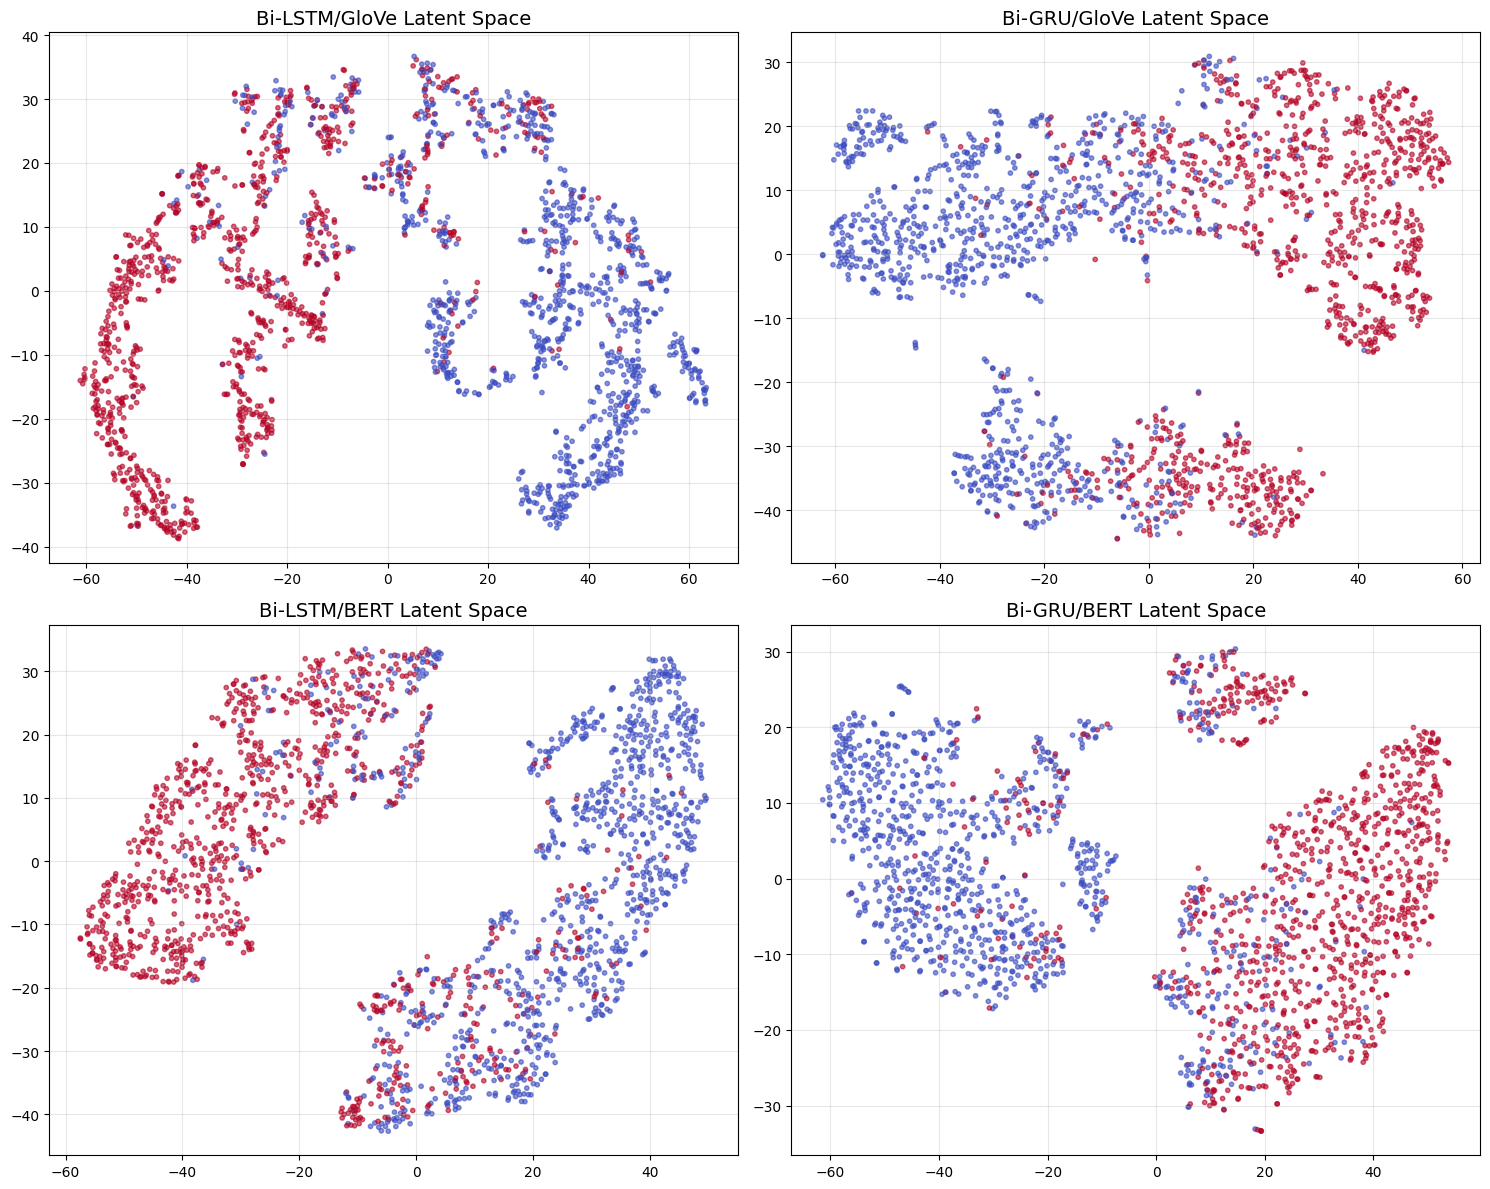

In [ ]:
# --- MASTER VISUALIZATION: ALL 4 MODELS (2x2 Grid) ---
# REPLACEMENT CELL: Includes Data Shuffling Fix

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, logging
from datasets import load_dataset, Dataset
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import os

# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# --- PART A: DATA & VOCAB SETUP ---
print("Loading IMDb dataset...")
logging.set_verbosity_error()
imdb = load_dataset("imdb")

# !!! CRITICAL FIX: Shuffle to ensure we get both Positive and Negative examples !!!
print("Shuffling test data...")
shuffled_test = imdb['test'].shuffle(seed=42)

# Re-build GloVe Vocab (Top 25k words) - CRITICAL for GloVe models to work
print("Rebuilding GloVe vocabulary...")
all_tokens = [token for text in imdb['train']['text'] for token in text.lower().split()]
word_counts = Counter(all_tokens)
sorted_vocab = [word for word, count in word_counts.most_common(25000 - 2)]
word_to_index = {"<unk>": 0, "<pad>": 1}
for word in sorted_vocab:
    word_to_index[word] = len(word_to_index)

# Tokenizer Functions
def tokenize_glove(text):
    tokens = text.lower().split()
    # Numericalize, truncate/pad to 256
    ids = [word_to_index.get(t, 0) for t in tokens]
    if len(ids) > 256: ids = ids[:256]
    else: ids += [1] * (256 - len(ids))
    return torch.tensor(ids, dtype=torch.long)

bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_bert(batch):
    return bert_tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)

# Prepare Test Data (Subset for Visualization Speed)
print("Preparing Test Data Subset (2000 samples)...")
# We take the first 2000 from the SHUFFLED dataset
test_data_raw = {'text': shuffled_test['text'][:2000], 'label': shuffled_test['label'][:2000]}
hf_test = Dataset.from_dict(test_data_raw)

# Check distribution to be safe
labels_array = np.array(test_data_raw['label'])
print(f"Subset Distribution: {np.sum(labels_array==0)} Negatives, {np.sum(labels_array==1)} Positives")

# 1. GloVe DataLoader
glove_tensors = [tokenize_glove(t) for t in test_data_raw['text']]
glove_labels = torch.tensor(test_data_raw['label'])
glove_dataset = data.TensorDataset(torch.stack(glove_tensors), glove_labels)
glove_iterator = data.DataLoader(glove_dataset, batch_size=32, shuffle=False)

# 2. BERT DataLoader
bert_data = hf_test.map(tokenize_bert, batched=True, remove_columns=['text'])
bert_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
bert_iterator = data.DataLoader(bert_data, batch_size=32, shuffle=False)

# --- PART B: MODEL DEFINITIONS ---
class RNNClassifier(nn.Module): # GloVe
    def __init__(self, rnn_type):
        super().__init__()
        self.rnn_type = rnn_type
        self.embedding = nn.Embedding(25000, 300, padding_idx=1)
        # Architecture must match training: Hidden=256, Layers=2
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(300, 256, num_layers=2, bidirectional=True, dropout=0.5, batch_first=True)
        else:
            self.rnn = nn.GRU(300, 256, num_layers=2, bidirectional=True, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(256 * 2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward_latent(self, text):
        embedded = self.dropout(self.embedding(text))
        if self.rnn_type == 'LSTM':
            _, (hidden, _) = self.rnn(embedded)
        else:
            _, hidden = self.rnn(embedded)
        return torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

class ContextualRNNClassifier(nn.Module): # BERT
    def __init__(self, rnn_type):
        super().__init__()
        self.rnn_type = rnn_type
        self.bert_encoder = AutoModel.from_pretrained('distilbert-base-uncased')
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(768, 256, num_layers=2, bidirectional=True, dropout=0.5, batch_first=True)
        else:
            self.rnn = nn.GRU(768, 256, num_layers=2, bidirectional=True, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(256 * 2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward_latent(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert_encoder(input_ids, attention_mask)
        if self.rnn_type == 'LSTM':
            _, (hidden, _) = self.rnn(outputs.last_hidden_state)
        else:
            _, hidden = self.rnn(outputs.last_hidden_state)
        return torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

# --- PART C: EXECUTION & PLOTTING ---
model_configs = [
    ("Bi-LSTM/GloVe", "Bi-LSTM_GloVe_T4_best.pt", "LSTM", "GloVe"),
    ("Bi-GRU/GloVe",  "Bi-GRU_GloVe_T4_best.pt",  "GRU",  "GloVe"),
    ("Bi-LSTM/BERT",  "Bi-LSTM_BERT_T4_best.pt",  "LSTM", "BERT"),
    ("Bi-GRU/BERT",   "Bi-GRU_BERT_T4_best.pt",   "GRU",  "BERT")
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

print("\nStarting Extraction and Plotting Loop...")

for i, (name, filename, rnn_type, emb_type) in enumerate(model_configs):
    ax = axes[i]
    print(f"Processing {name}...")

    # 1. Init Model
    if emb_type == "GloVe":
        model = RNNClassifier(rnn_type).to(device)
        iterator = glove_iterator
    else:
        model = ContextualRNNClassifier(rnn_type).to(device)
        iterator = bert_iterator

    # 2. Load Weights
    if os.path.exists(filename):
        model.load_state_dict(torch.load(filename, map_location=device))
    else:
        print(f"⚠️ Warning: {filename} not found. Skipping plot.")
        ax.text(0.5, 0.5, "File Not Found", ha='center')
        continue

    # 3. Extract Vectors
    model.eval()
    vecs, lbls = [], []
    with torch.no_grad():
        for batch in iterator:
            if emb_type == "GloVe":
                text, y = batch
                text = text.to(device)
                v = model.forward_latent(text)
            else:
                ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                y = batch['label']
                v = model.forward_latent(ids, mask)

            vecs.append(v.cpu().numpy())
            lbls.append(y.numpy())

    X = np.concatenate(vecs)
    y = np.concatenate(lbls)

    # 4. t-SNE
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
    X_2d = tsne.fit_transform(X)

    # 5. Plot
    scatter = ax.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='coolwarm', alpha=0.6, s=10)
    ax.set_title(f"{name} Latent Space", fontsize=14)
    ax.grid(True, alpha=0.3)

os.makedirs('outputs', exist_ok=True)
plt.tight_layout()
plt.savefig("outputs/Q1_All_Models_Comparison.png", dpi=300)
print("\n✅ Comparison Plot saved to outputs/Q1_All_Models_Comparison.png")
plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt

# 1. Create the missing folder
os.makedirs('outputs', exist_ok=True)

# 2. Save the plot (it is likely still in memory!)
try:
    plt.savefig("outputs/Q1_All_Models_Comparison.png", dpi=300)
    print("✅ Success! Plot saved to outputs/Q1_All_Models_Comparison.png")
except:
    print("⚠️ Plot was lost from memory. Please re-run the big visualization code block one last time.")

✅ Success! Plot saved to outputs/Q1_All_Models_Comparison.png


<Figure size 640x480 with 0 Axes>